# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [130]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN


# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [4]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

*Take a look at the head of the data to have an idea of how it looks like:*

In [111]:
print(customers.shape)
customers.head()


(440, 7)


,Channel,Region,Fresh,Milk,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,214,2674,1338
1,2,3,7057,9810,1762,3293,1776
2,2,3,6353,8808,2405,3516,7844
3,1,3,13265,1196,6404,507,1788
4,2,3,22615,5410,3915,1777,5185


*Any string like columns?:*

In [9]:
customers.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

*What about the null values?:*

In [10]:
customers.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

*Let's look at how the variables relate to each other. I will plot them by channel (restaurants, hotels, and coffes or retail shops) to have a better insight*

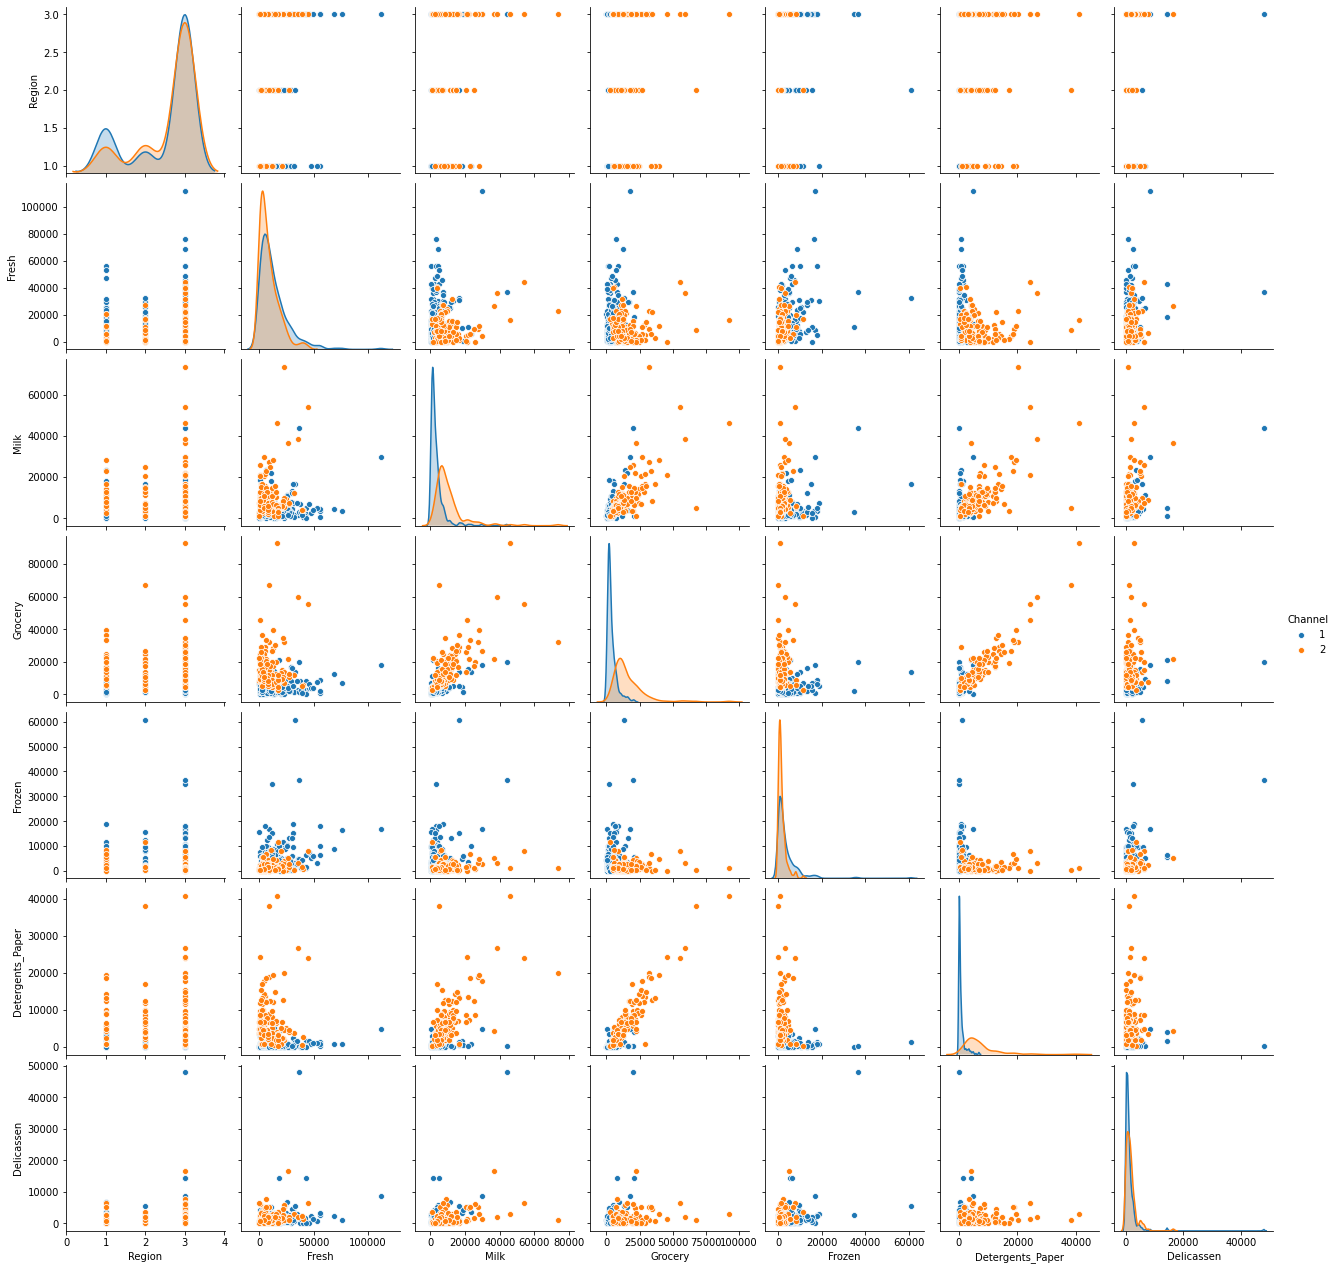

In [14]:
sns.pairplot(customers, hue = 'Channel')

*I'll take a look at the distribution of the numeric variables by using boxplots*

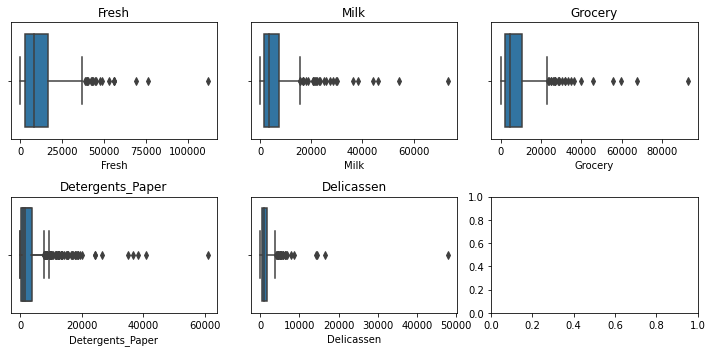

In [91]:
f, ax = plt.subplots(2,3, figsize=(10,5))
for i, e in enumerate(customers.columns[2:]):
    sns.boxplot(customers[e], ax = ax[i//3,(i if i<3 else i//5)])
    ax[i//3,(i if i<3 else i//5)].set_title(e)
f.tight_layout()

*The data is quite clean without null values and with numerical features. However, two points might need to be addressed.* 
    - One is a high correlation among two variables, groceries and detergents, at least for the retails shops, and it seems quite uninformative for the other channel, so I might eliminate one.
    - The second issue is the presence of outlayers in most of the other variables.

*I don't know what I am doing here:*

In [93]:
customers['total'] = customers[customers.columns[2:]].sum(axis=1)
customers.sort_values('total', ascending=False)
len(customers)*0.2

88.0

In [98]:
customers[:88]['total'].sum()

7654668

In [99]:
customers[88:]['total'].sum()*0.8

17267465.6

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [104]:
customers.drop(['Grocery', 'total'], axis = 1, inplace=True)

In [110]:
customers

,Channel,Region,Fresh,Milk,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,214,2674,1338
1,2,3,7057,9810,1762,3293,1776
2,2,3,6353,8808,2405,3516,7844
3,1,3,13265,1196,6404,507,1788
4,2,3,22615,5410,3915,1777,5185
...,...,...,...,...,...,...,...
435,1,3,29703,12051,13135,182,2204
436,1,3,39228,1431,4510,93,2346
437,2,3,14531,15488,437,14841,1867
438,1,3,10290,1981,1038,168,2125


*I will remove the outlayers from the data by using the z-score method. If the z score is completely outside of the area of a normal distribution:https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561*

In [112]:
customers_clean = customers[(np.abs(stats.zscore(customers)) < 3).all(axis=1)]

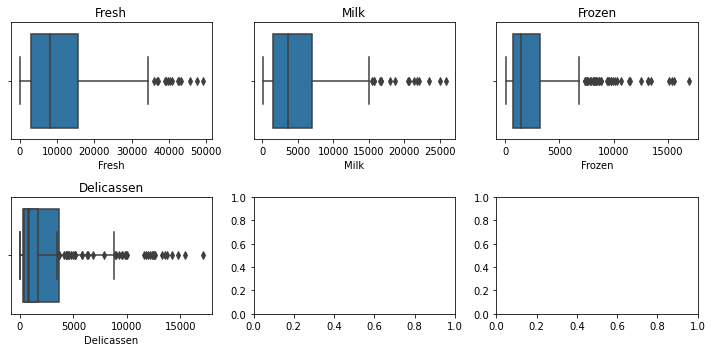

In [120]:
f, ax = plt.subplots(2,3, figsize=(10,5))
for i, e in enumerate(customers_clean.columns[2:]):
    sns.boxplot(customers_clean[e], ax = ax[i//3,(i if i<3 else i//5)])
    ax[i//3,(i if i<3 else i//5)].set_title(e)
f.tight_layout()

*There are still some high values, but the distributions look much better*

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [119]:
scaler = StandardScaler()
customers_scale = pd.DataFrame(scaler.fit_transform(customers_clean), columns = customers_clean.columns)
customers_scale

,Channel,Region,Fresh,Milk,Frozen,Detergents_Paper,Delicassen
0,1.472392,0.590412,0.201653,1.038185,-0.800210,0.084503,0.083488
1,1.472392,0.590412,-0.370782,1.071803,-0.268611,0.275225,0.444048
2,1.472392,0.590412,-0.442591,0.853068,-0.047798,0.343935,5.439204
3,-0.679167,0.590412,0.262446,-0.808613,1.325500,-0.583180,0.453926
4,1.472392,0.590412,1.216164,0.111293,0.470752,-0.191876,3.250325
...,...,...,...,...,...,...,...
410,-0.679167,0.590412,1.939154,1.561008,3.636996,-0.683318,0.796376
411,-0.679167,0.590412,2.910723,-0.757314,0.675081,-0.710740,0.913270
412,1.472392,0.590412,0.391581,2.311297,-0.723629,3.833326,0.518959
413,-0.679167,0.590412,-0.041010,-0.637250,-0.517240,-0.687631,0.731344


# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [172]:
model = KMeans(n_clusters=4).fit(customers_scale)

customers_scale['labels'] = model.labels_

customers_scale.head()

,Channel,Region,Fresh,Milk,Frozen,Detergents_Paper,Delicassen,labels,labels_DBSCAN
0,1.472392,0.590412,0.201653,1.038185,-0.800210,0.084503,0.083488,1,-1
1,1.472392,0.590412,-0.370782,1.071803,-0.268611,0.275225,0.444048,1,-1
2,1.472392,0.590412,-0.442591,0.853068,-0.047798,0.343935,5.439204,1,-1
3,-0.679167,0.590412,0.262446,-0.808613,1.325500,-0.583180,0.453926,2,-1
4,1.472392,0.590412,1.216164,0.111293,0.470752,-0.191876,3.250325,2,-1


Count the values in `labels`.

In [173]:
customers_scale.labels.value_counts()

0    199
2     92
1     83
3     41
Name: labels, dtype: int64

# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [170]:
model_dbscan = DBSCAN(eps=0.5).fit(customers_scale[customers_scale.columns[:-1]])
customers_scale['labels_DBSCAN'] = model_dbscan.labels_

Count the values in `labels_DBSCAN`.

In [171]:
customers_scale.labels_DBSCAN.value_counts()

-1    333
 1     76
 0      6
Name: labels_DBSCAN, dtype: int64

# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

Text(0.5, 1.0, 'K-means')

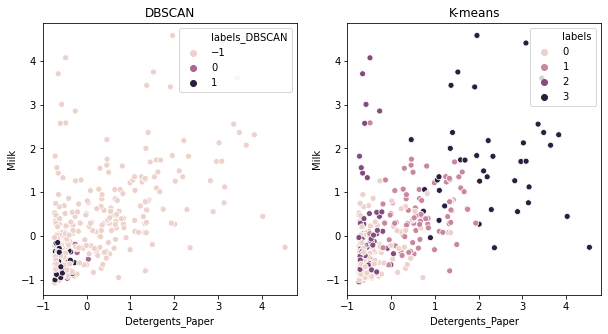

In [178]:
f, ax = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(customers_scale.Detergents_Paper, customers_scale.Milk, hue=customers_scale.labels_DBSCAN, ax = ax[0])
ax[0].set_title('DBSCAN')
sns.scatterplot(customers_scale.Detergents_Paper, customers_scale.Milk, hue=customers_scale.labels, ax = ax[1])
ax[1].set_title('K-means')

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

*I got rid of the Grocery column*


Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

Text(0.5, 1.0, 'K-means')

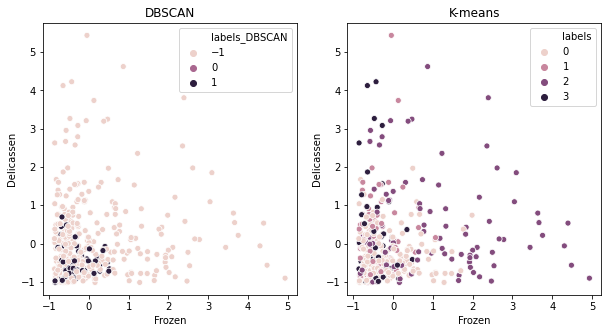

In [177]:
f, ax = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(customers_scale.Frozen, customers_scale.Delicassen, hue=customers_scale.labels_DBSCAN, ax = ax[0])
ax[0].set_title('DBSCAN')
sns.scatterplot(customers_scale.Frozen, customers_scale.Delicassen, hue=customers_scale.labels, ax = ax[1])
ax[1].set_title('K-means')


Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [155]:
customers_scale.groupby('labels_DBSCAN').mean()

,Channel,Region,Fresh,Milk,Frozen,Detergents_Paper,Delicassen,labels
labels_DBSCAN,,,,,,,,
-1,0.167242,-0.145387,0.116361,0.168046,0.096901,0.145865,0.128695,1.630631
0,-0.679167,0.590412,-0.569261,-0.267417,-0.666509,-0.220068,-0.427443,2.000000
1,-0.679167,0.590412,-0.464903,-0.715196,-0.371959,-0.621743,-0.530140,2.000000


In [154]:
customers_scale.groupby('labels').mean()

,Channel,Region,Fresh,Milk,Frozen,Detergents_Paper,Delicassen,labels_DBSCAN
labels,,,,,,,,
0,-0.518944,0.314581,1.088049,-0.102989,1.057531,-0.526917,0.530685,-1.00000
1,1.472392,0.446367,-0.224123,0.494254,-0.451542,0.676051,0.043538,-1.00000
2,-0.679167,0.541675,-0.429412,-0.504638,-0.346539,-0.487790,-0.368404,0.18797
3,-0.552605,-1.754559,-0.048313,-0.453039,0.002679,-0.436310,-0.291756,-1.00000
4,1.472392,-0.473307,-0.608347,1.732562,-0.433985,2.290133,0.395543,-1.00000


Which algorithm appears to perform better?

*I am not sure how we can check for better performance by looking at the means, but according to the scatterplots, k-means seem to have done better in this case*

# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

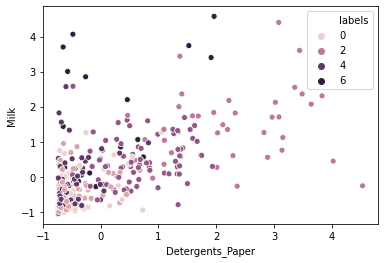

In [194]:
model = KMeans(n_clusters=6).fit(customers_scale)
customers_scale['labels'] = model.labels_
sns.scatterplot(customers_scale.Detergents_Paper, customers_scale.Milk, hue=customers_scale.labels)


*My conclussion is that it is quite difficult to determine the best parameter by just looking at a 2 dimensional scatter plot for a multidimensional model :P*

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

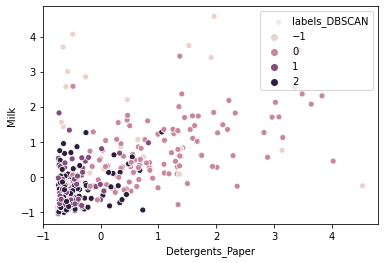

In [204]:
model_dbscan = DBSCAN(eps=2).fit(customers_scale[customers_scale.columns[:-1]])
customers_scale['labels_DBSCAN'] = model_dbscan.labels_
sns.scatterplot(customers_scale.Detergents_Paper, customers_scale.Milk, hue=customers_scale.labels_DBSCAN)


In [ ]:
# Your comment here